In [1]:
from __future__ import print_function

import os
import random
from collections import Counter, defaultdict as dd
from time import time
import json

from PIL import Image, ImageDraw, ImageFont
import exifread
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

from umap import UMAP
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import MiniBatchDictionaryLearning, SparseCoder, TruncatedSVD
import joblib
from labelme.utils.draw import label_colormap, draw_label
from scipy.spatial import ConvexHull

/usr/local/lib/python2.7/dist-packages/numba/errors.py:104: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


# Tentative solution

## Model training

### Constants and functions

In [2]:
# INPUT_DIR = "src"
# OUTPUT_DIR = "out"
INPUT_DIR = "new-photos"
OUTPUT_DIR = "new-photos-out"

In [3]:
def get_filenames():
    source_data, labeled_data = sorted(os.listdir(INPUT_DIR)), os.listdir(OUTPUT_DIR)
    label_mask_filenames, label_list_filenames = [], []
    for filename in source_data:
        # assert filename.endswith(".jpg") and filename[:-4] in labeled_data
        assert filename[-4:] in (".jpg", ".png") and filename[:-4] in labeled_data
        path_prefix = "%s/%s/" % (OUTPUT_DIR, filename[:-4])
        label_mask_filenames.append(path_prefix + "label.png")
        label_list_filenames.append(path_prefix + "label_names.txt")
    return np.array(source_data), label_mask_filenames, label_list_filenames

In [4]:
def get_raw_images(source_data, input_dir=INPUT_DIR):
    raw_images = {}
    for filename in source_data:
        full_path = os.path.join(input_dir, filename)
        raw_images[filename] = np.asarray(Image.open(full_path))
    return raw_images

In [5]:
def get_label_name_to_value_mapping(label_list_filenames):
    label_name_to_value_mapping = {}
    for filename in label_list_filenames:
        with open(filename) as f:
            for line in f:
                line = line.strip()
                if line not in label_name_to_value_mapping:
                    label_name_to_value_mapping[line] = len(label_name_to_value_mapping)
    return label_name_to_value_mapping

def get_labels(source_data, label_mask_filenames, label_list_filenames):
    label_name_to_value_mapping = get_label_name_to_value_mapping(label_list_filenames)
    # print(label_name_to_value_mapping)
    labels = {}
    for filename, mask_path, list_path in zip(source_data, label_mask_filenames, label_list_filenames):
        mask_as_arr = np.asarray(Image.open(mask_path))
        with open(list_path) as f:
            local_mapping = {i: line.strip() for i, line in enumerate(f)}
        # print(filename, local_mapping)
        to_global_label = np.vectorize(lambda x: label_name_to_value_mapping[local_mapping[x]])
        labels[filename] = to_global_label(mask_as_arr)
    return labels, label_name_to_value_mapping

In [6]:
A = 10 # tile side length in pixels
B = 8 # reduced dimensionality of a vector representing each tile

In [7]:
def to_X_y(filename_list, raw_images, labels):
    assert raw_images.keys() == labels.keys()
    Xs, ys, filename_indices = [], [], []
    for idx, filename in enumerate(filename_list):
        assert filename in raw_images
        img_as_arr = raw_images[filename]
        tile_count_h, tile_count_w = img_as_arr.shape[0] // A, img_as_arr.shape[1] // A
        # print(tile_count_h, tile_count_w)
        img_tiles = np.array([img_as_arr[A*i:A*(i+1),A*j:A*(j+1),:].flatten()
                              for i in range(tile_count_h) for j in range(tile_count_w)])
        Xs.append(img_tiles)
        mask_as_arr = labels[filename]
        mask_tiles = np.array([np.bincount(mask_as_arr[A*i:A*(i+1),A*j:A*(j+1)].flatten()).argmax()
                               for i in range(tile_count_h) for j in range(tile_count_w)])
        ys.append(mask_tiles)
        filename_indices.append(idx * np.ones(mask_tiles.shape))
    return np.vstack(Xs), np.concatenate(ys), np.concatenate(filename_indices)

In [8]:
def make_projector(X):
    # Very slow with UMAP, still slow at runtime with SparseCoder
    SAMPLE_SIZE = 20000
    indices_subset = random.sample(range(X.shape[0]), SAMPLE_SIZE)
    dct_learner = TruncatedSVD(n_components=B)
    dct_learner.fit(X[indices_subset])
    # return SparseCoder(dictionary=dct_learner.components_, n_jobs=4)
    return dct_learner

In [9]:
def pretty_print_confusion_matrix(y_test, y_pred, label_name_to_value_mapping):
    labels = {v: k for k, v in label_name_to_value_mapping.items()}
    label_names = sorted(label_name_to_value_mapping)
    matrix = confusion_matrix([labels[x] for x in y_test], [labels[x] for x in y_pred], labels=label_names)
    label_names_prettified = [x[:8] if len(x) > 8 else x.ljust(8) if len(x) < 8 else x for x in label_names]
    print("\t" + "\t".join(label_names_prettified))
    for i, row in enumerate(matrix):
        print("\t".join([label_names_prettified[i]] + [str(x) for x in row]))
    for i, label in enumerate(label_names_prettified):
        p = float(matrix[i, i]) / sum(matrix[i, :]) if sum(matrix[i, :]) > 0 else 0.0
        r = float(matrix[i, i]) / sum(matrix[:, i]) if sum(matrix[:, i]) > 0 else 0.0
        f = 2 * p * r / (p + r) if p + r > 0 else 0.0
        print("%s\tP=%.4f\tR=%.4f\tF=%.4f" % (label, p, r, f))

def leave_one_out_evaluation(filename_list, X, y, filename_indices, clf, label_names):
    # print(sorted(label_names))
    ys_test, ys_pred = [], []
    for idx, filename in enumerate(filename_list):
        print(filename)
        X_train, X_test = X[filename_indices != idx], X[filename_indices == idx]
        y_train, y_test = y[filename_indices != idx], y[filename_indices == idx]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        input_image_shape = (2250, 4000) # TODO: remove hardcode
        predicted_mask = tile_classes_to_output(y_pred, input_image_shape)
        predicted_mask_small = tile_classes_to_output_small(y_pred, input_image_shape)
        predicted_img = mask_to_image(predicted_mask)
        predicted_img.save(open("crossval-predicted/mask_" + filename[:-4] + ".png", "wb"), format="PNG")
        predicted_img_small = mask_to_image(predicted_mask_small)
        predicted_img_small.save(open("crossval-predicted/mask_small_" + filename[:-4] + ".png", "wb"), format="PNG")
        preds = [y_pred]
        refinement_iter_time = 0.0
        for zz in range(5):
            t1 = time()
            predicted_mask_small = refine_small_mask(predicted_mask_small)
            t2 = time()
            refinement_iter_time += (t2 - t1)
            predicted_img_small = mask_to_image(predicted_mask_small)
            predicted_img_small.save(open("crossval-predicted/mask_small_" + filename[:-4] + "_r%s.png" % (zz + 1), "wb"), format="PNG")
            preds.append(predicted_mask_small.flatten())
        print("5 refinement iterations complete in %.6f s" % refinement_iter_time)
        orig_img = raw_images[filename] # TODO: remove hardcode
        blended_img = Image.fromarray(draw_label(predicted_mask, orig_img, label_names=sorted(label_names)))
        blended_img.save(open("crossval-predicted/viz_" + filename[:-4] + ".png", "wb"), format="PNG")
        for refinement_iter, y_pred in enumerate(preds):
            print("Accuracy with %s refinements: %.4f" % (refinement_iter, accuracy_score(y_test, y_pred)))
        # pretty_print_confusion_matrix(y_test, y_pred, label_names)
        ys_test.append(y_test)
        ys_pred.append(y_pred)
        print()
    y_test_all, y_pred_all = np.concatenate(ys_test), np.concatenate(ys_pred)
    print("------------------")
    print("Overall accuracy: %.4f" % accuracy_score(y_test_all, y_pred_all))
    pretty_print_confusion_matrix(y_test_all, y_pred_all, label_names)

In [210]:
TOLERANCE_IN_3x3_SUBMASK = 5 # out of 8 (9 - 1)

def refine_small_mask(mask):
    assert len(mask.shape) == 2
    h, w = mask.shape
    refined_mask = mask.copy()
    for i in range(1, h - 1):
        for j in range(1, w - 1):
            submask = mask[i-1:i+2,j-1:j+2].flatten()
            bincount = np.bincount(submask)
            most_frequent_label = np.argmax(bincount)
            if bincount[most_frequent_label] >= TOLERANCE_IN_3x3_SUBMASK:
                refined_mask[i,j] = most_frequent_label
    return refined_mask

In [14]:
def train_and_save(clf, X, y, path):
    clf.fit(X, y)
    joblib.dump(clf, path)

### Workflow

In [15]:
source_data, label_mask_filenames, label_list_filenames = get_filenames()

In [16]:
%%time
raw_images = get_raw_images(source_data)

CPU times: user 1.37 s, sys: 243 ms, total: 1.61 s
Wall time: 1.76 s


In [17]:
%%time
labels, label_name_to_value_mapping = get_labels(source_data, label_mask_filenames, label_list_filenames)

CPU times: user 21.5 s, sys: 190 ms, total: 21.7 s
Wall time: 21.9 s


In [18]:
%%time
X, y, filename_indices = to_X_y(source_data, raw_images, labels)

CPU times: user 5.23 s, sys: 101 ms, total: 5.33 s
Wall time: 5.33 s


In [19]:
X.shape

(1080000, 300)

In [20]:
projector = make_projector(X)

In [21]:
%%time
X_low_dim = projector.transform(X)

CPU times: user 4.17 s, sys: 962 ms, total: 5.13 s
Wall time: 996 ms


In [22]:
# clf = KNeighborsClassifier(n_neighbors=10, n_jobs=4)
clf = RandomForestClassifier(n_estimators=10, max_depth=7, n_jobs=4)

In [ ]:
!mkdir crossval-predicted

In [27]:
%%time
leave_one_out_evaluation(source_data, X_low_dim, y, filename_indices, clf, label_name_to_value_mapping)

DJI_0098.jpg
10 refinement iterations complete in 2.344026 s
Accuracy with 0 refinements: 0.8675
Accuracy with 1 refinements: 0.8739
Accuracy with 2 refinements: 0.8757
Accuracy with 3 refinements: 0.8768
Accuracy with 4 refinements: 0.8775
Accuracy with 5 refinements: 0.8784

DJI_0099.jpg
10 refinement iterations complete in 2.423827 s
Accuracy with 0 refinements: 0.8925
Accuracy with 1 refinements: 0.8959
Accuracy with 2 refinements: 0.8970
Accuracy with 3 refinements: 0.8978
Accuracy with 4 refinements: 0.8984
Accuracy with 5 refinements: 0.8987

DJI_0100.jpg
10 refinement iterations complete in 2.406439 s
Accuracy with 0 refinements: 0.9294
Accuracy with 1 refinements: 0.9369
Accuracy with 2 refinements: 0.9390
Accuracy with 3 refinements: 0.9401
Accuracy with 4 refinements: 0.9409
Accuracy with 5 refinements: 0.9416

DJI_0101.jpg
10 refinement iterations complete in 2.726024 s
Accuracy with 0 refinements: 0.9165
Accuracy with 1 refinements: 0.9249
Accuracy with 2 refinements: 0.92

In [84]:
# !mkdir models
!mkdir models/detect_artifacts

In [53]:
clf = KNeighborsClassifier(n_neighbors=10, n_jobs=4)
train_and_save(clf, X_low_dim, y, "models/clf_knn_n10.model")

In [85]:
clf = RandomForestClassifier(n_estimators=10, max_depth=7, n_jobs=4)
# train_and_save(clf, X_low_dim, y, "models/clf_rf_e10_d7.model")
train_and_save(clf, X_low_dim, y, "models/detect_artifacts/clf_rf_e10_d7.model")

In [86]:
# _ = joblib.dump(projector, "models/projector.model")
_ = joblib.dump(projector, "models/detect_artifacts/projector.model")

In [89]:
model_metadata = {
    "labels": sorted(label_name_to_value_mapping),
    "A": 10
}

In [91]:
json.dump(model_metadata, open("models/detect_artifacts/metadata.json", "w"))

### Runtime

Drafts only, the actual implementation is in the script `process_image.py`.

Runtime workflow:
- image to $(h,\, w,\, 3)$ input array - handled in the wrapper
- $(h,\, w,\, 3)$ input array to $\left(\frac{hw}{a^2},\, 3a^2\right)$ array, $a=18$ - by numpy manipulations
- $\left(\frac{hw}{a^2},\, 3a^2\right)$ array to $\left(\frac{hw}{d^2},\, b\right)$ array, $b \ll a$ - via SparseCoder
- $\left(\frac{hw}{d^2},\, b\right)$ array to $\left(\frac{hw}{d^2},\right)$ array of predicted classes - in the classifier
- $\left(\frac{hw}{d^2},\right)$ array of predicted classes to $(h,\, w)$ output array
- $(h,\, w)$ output array to image - handled in the wrapper

In [33]:
PROJECTOR_PATH = "models/projector.model"
CLF_PATH = "models/clf_rf_e10_d7.model"

In [34]:
def get_model():
    projector = joblib.load(PROJECTOR_PATH)
    clf = joblib.load(CLF_PATH)
    return projector, clf

In [36]:
A = 10 # 18 # tile side length in pixels
B = 4 # reduced dimensionality of a vector representing each tile

In [37]:
def input_to_tile_vectors(arr):
    assert len(arr.shape) == 3 and arr.shape[-1] == 3
    tile_count_h, tile_count_w = arr.shape[0] // A, arr.shape[1] // A
    tile_vectors = np.array([arr[A*i:A*(i+1),A*j:A*(j+1),:].flatten()
                             for i in range(tile_count_h) for j in range(tile_count_w)])
    return tile_vectors

In [23]:
def tile_classes_to_output_small(tile_classes, shape):
    assert len(shape) == 2
    tile_count_h, tile_count_w = shape[0] // A, shape[1] // A
    assert tile_count_h * tile_count_w == len(tile_classes)
    return tile_classes.reshape((tile_count_h, tile_count_w))

In [24]:
def tile_classes_to_output(tile_classes, shape):
    assert len(shape) == 2
    output = np.zeros(shape, dtype=np.uint8)
    tile_count_h, tile_count_w = shape[0] // A, shape[1] // A
    assert tile_count_h * tile_count_w == len(tile_classes)
    idx = 0
    for i in range(tile_count_h):
        for j in range(tile_count_w):
            output[A*i:A*(i+1),A*j:A*(j+1)] = tile_classes[idx]
            idx += 1
    return output

In [39]:
def predict_mask(img_as_arr):
    projector, clf = get_model() # TODO: Move into an object, in order not to reload for each input
    tile_vectors = input_to_tile_vectors(img_as_arr)
    tile_vectors_low_dimensional = projector.transform(tile_vectors)
    tile_classes = clf.predict(tile_vectors_low_dimensional)
    output_mask = tile_classes_to_output(tile_classes, img_as_arr.shape[:2])
    return output_mask

In [25]:
def mask_to_image(mask):
    # Encoding classes with a colormap, see /usr/local/lib/python2.7/dist-packages/labelme/utils/_io.py
    assert mask.min() >= -1 and mask.max() < 255
    mask_pil = Image.fromarray(mask.astype(np.uint8), mode='P')
    colormap = label_colormap(255)
    mask_pil.putpalette((colormap * 255).astype(np.uint8).flatten())
    return mask_pil

# GPS positioning

In [40]:
def to_float(coord):
    degrees, minutes, seconds = coord.values
    return degrees.num / (1.0 * degrees.den) + minutes.num / (60.0 * minutes.den) + seconds.num / (3600.0 * seconds.den)

In [41]:
image_dir = "new-photos"
longitudes, latitudes = [], []
for filename in sorted(os.listdir(image_dir)):
    with open(os.path.join(image_dir, filename), "rb") as f:
        tags = exifread.process_file(f)
        longitudes.append(to_float(tags["GPS GPSLongitude"]))
        latitudes.append(to_float(tags["GPS GPSLatitude"]))

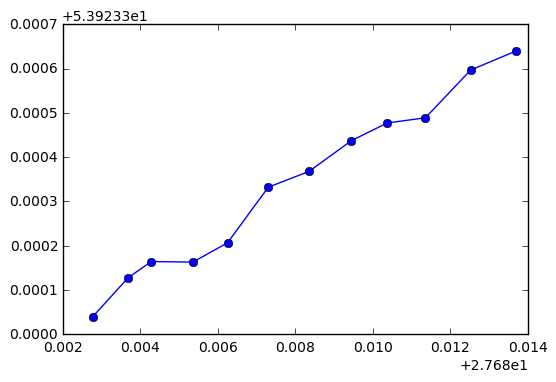

In [42]:
_ = plt.plot(longitudes, latitudes, "-o")

In [43]:
tags

{'EXIF ApertureValue': (0x9202) Ratio=227/100 @ 1375,
 'EXIF ColorSpace': (0xA001) Short=sRGB @ 432,
 'EXIF ComponentsConfiguration': (0x9101) Undefined=CrCbY @ 276,
 'EXIF CompressedBitsPerPixel': (0x9102) Ratio=3879079/1125000 @ 1359,
 'EXIF Contrast': (0xA408) Short=Normal @ 600,
 'EXIF CustomRendered': (0xA401) Short=Normal @ 516,
 'EXIF DateTimeDigitized': (0x9004) ASCII=2019:05:18 09:37:19 @ 1339,
 'EXIF DateTimeOriginal': (0x9003) ASCII=2019:05:18 09:37:19 @ 1319,
 'EXIF DeviceSettingDescription': (0xA40B) Undefined=[0, 0, 0, 0] @ 636,
 'EXIF DigitalZoomRatio': (0xA404) Ratio=0/0 @ 1679,
 'EXIF ExifImageLength': (0xA003) Long=2250 @ 456,
 'EXIF ExifImageWidth': (0xA002) Long=4000 @ 444,
 'EXIF ExifVersion': (0x9000) Undefined=0230 @ 240,
 'EXIF ExposureBiasValue': (0x9204) Signed Ratio=0 @ 1383,
 'EXIF ExposureIndex': (0xA215) Ratio=0/0 @ 1671,
 'EXIF ExposureMode': (0xA402) Short=Manual Exposure @ 528,
 'EXIF ExposureProgram': (0x8822) Short=Manual @ 216,
 'EXIF ExposureTime': 

## Boundary detection

In [230]:
def leave_one_out_single_image(filename_list, filename_idx, X, y, filename_indices, clf, label_names):
    ys_test, ys_pred = [], []
    idx, filename = filename_idx, filename_list[filename_idx]
    if True: # this is a dummy condition, safe to remove
        print(filename)
        X_train, X_test = X[filename_indices != idx], X[filename_indices == idx]
        y_train, y_test = y[filename_indices != idx], y[filename_indices == idx]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        input_image_shape = (2250, 4000) # TODO: remove hardcode
        predicted_mask = tile_classes_to_output(y_pred, input_image_shape)
        predicted_mask_small = tile_classes_to_output_small(y_pred, input_image_shape)
        predicted_img = mask_to_image(predicted_mask)
        predicted_img.save(open("crossval-predicted/mask_" + filename[:-4] + ".png", "wb"), format="PNG")
        predicted_img_small = mask_to_image(predicted_mask_small)
        predicted_img_small.save(open("crossval-predicted/mask_small_" + filename[:-4] + ".png", "wb"), format="PNG")
        preds = [y_pred]
        refinement_iter_time = 0.0
        for zz in range(5):
            t1 = time()
            predicted_mask_small = refine_small_mask(predicted_mask_small)
            t2 = time()
            refinement_iter_time += (t2 - t1)
            predicted_img_small = mask_to_image(predicted_mask_small)
            predicted_img_small.save(open("crossval-predicted/mask_small_" + filename[:-4] + "_r%s.png" % (zz + 1), "wb"), format="PNG")
            preds.append(predicted_mask_small.flatten())
        return predicted_mask_small

In [246]:
mask = leave_one_out_single_image(source_data, 6, X_low_dim, y, filename_indices, clf, label_name_to_value_mapping)

DJI_0104.jpg


In [247]:
mask.shape

(225, 400)

In [248]:
sorted(label_name_to_value_mapping)

['_background_',
 'bush',
 'field',
 'field_shadowed',
 'non_field',
 'road',
 'trees']

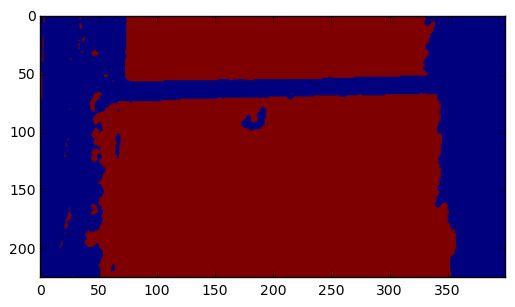

In [252]:
_ = plt.imshow(255 * np.uint8(mask == 2))

In [253]:
ys, xs = np.where(mask == 2)
X_pixel_coords = np.vstack([xs.reshape((1, -1)), ys.reshape((1, -1))]).T

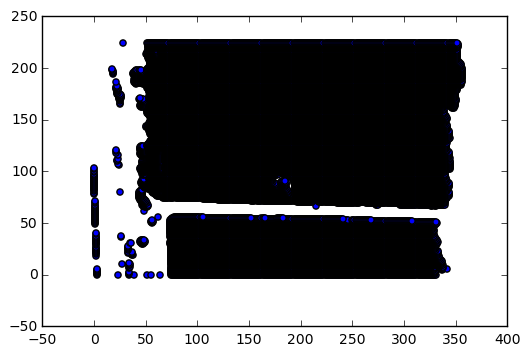

In [254]:
_ = plt.scatter(xs, ys)

In [255]:
X_pixel_coords.shape

(59908, 2)

In [256]:
clusterizer = DBSCAN(eps=1.01) # 1.42

In [257]:
clusterizer.fit(X_pixel_coords)

DBSCAN(algorithm='auto', eps=1.01, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=None, p=None)

In [258]:
y_pixel_coords = clusterizer.fit_predict(X_pixel_coords)

In [261]:
c = Counter(y_pixel_coords)
largest_class = sorted(c, key=lambda x: -c[x])[0]
for k in sorted(c, key=lambda x: -c[x]):
    print(k, c[k], sep="\t")

4	45398
0	14181
-1	157
3	77
5	35
1	22
7	16
2	8
9	8
6	3
8	3


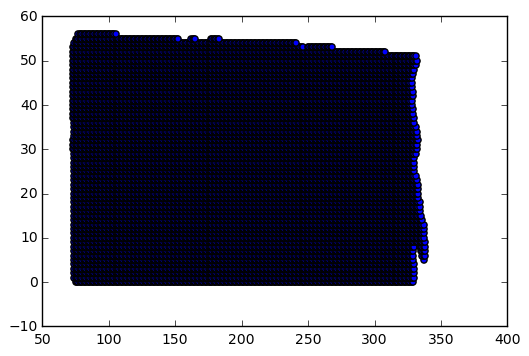

In [262]:
# _ = plt.scatter(X_pixel_coords.T[0], X_pixel_coords.T[1], c=y_pixel_coords)
_ = plt.scatter(X_pixel_coords[y_pixel_coords==0, 0], X_pixel_coords[y_pixel_coords==0, 1])

In [114]:
HUB_THRESHOLD = 0.2
PATCH_THRESHOLD = 0.05
big_hubs, small_patches = dd(list), dd(list)
total_class_pixels = X_pixel_coords.shape[0]
for class_label in c:
    if class_label < 0:
        continue
    # print(c[class_label], HUB_THRESHOLD * total_class_pixels, PATCH_THRESHOLD * total_class_pixels)
    if c[class_label] > HUB_THRESHOLD * total_class_pixels:
        big_hubs[class_label].append(X_pixel_coords[y_pixel_coords == class_label, :])
    elif c[class_label] < PATCH_THRESHOLD * total_class_pixels:
        small_patches[class_label].append(X_pixel_coords[y_pixel_coords == class_label, :])

In [263]:
# input_point_cloud = big_hubs[10][0]
input_point_cloud = X_pixel_coords[y_pixel_coords==0, :]
hull = ConvexHull(input_point_cloud)

In [179]:
hull.vertices

array([63325, 63050, 62491, 27783,  6808,  6204,   288,     0,   287,
        1751,  2047,  4709,  8306, 60772, 61348, 62490], dtype=int32)

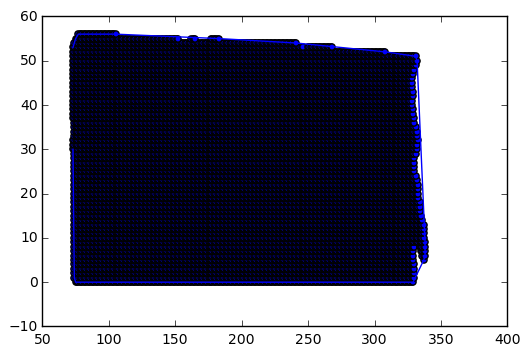

In [264]:
_ = plt.plot(input_point_cloud[hull.vertices, 0], input_point_cloud[hull.vertices, 1])
_ = plt.scatter(input_point_cloud.T[0], input_point_cloud.T[1])

* * *
# Older experiments

## Reading a single image

In [2]:
img = Image.open("src/IMG_160729_072508_0225_RGB.jpg")

In [3]:
img_as_arr = np.array(img)

In [4]:
img_as_arr.shape

(3456, 4608, 3)

In [5]:
xs = np.array([pixel[0] for row in img_as_arr for pixel in row])
ys = np.array([pixel[1] for row in img_as_arr for pixel in row])
zs = np.array([pixel[2] for row in img_as_arr for pixel in row])

In [6]:
SAMPLE_SIZE = 5000

In [7]:
indices = random.sample(range(xs.shape[0]), SAMPLE_SIZE)
xs_sample, ys_sample, zs_sample = xs[indices], ys[indices], zs[indices]

In [8]:
X = np.array(zip(xs_sample, ys_sample, zs_sample))

In [9]:
X.shape

(5000, 3)

## Splitting image into parts

In [10]:
DPI = 72

for i in range(3): # 48
    for j in range(3): # 64
        z = Image.fromarray(img_as_arr[DPI*i:DPI*(i+1),DPI*j:DPI*(j+1),:])

In [11]:
# font = ImageFont.load_default()
# font.getsize("A1")

In [14]:
draw = ImageDraw.Draw(img)
for i in range(64):
    for j in range(48):
        draw.rectangle(((DPI*i, DPI*j), (DPI*(i+1), DPI*(j+1))), outline="black") # width=4
# draw.text((36, 36), "A1", (0, 0, 0), font=font)

In [46]:
# img

## Tile clustering with dimensionality reduction

In [20]:
X_tiles = np.array([img_as_arr[DPI*i:DPI*(i+1),DPI*j:DPI*(j+1),:].flatten() for i in range(48) for j in range(64)])

In [21]:
X_tiles.shape

(3072, 15552)

In [22]:
clf = UMAP(n_neighbors=30) # default is 15

In [23]:
X_tiles_transformed = clf.fit_transform(X_tiles)

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


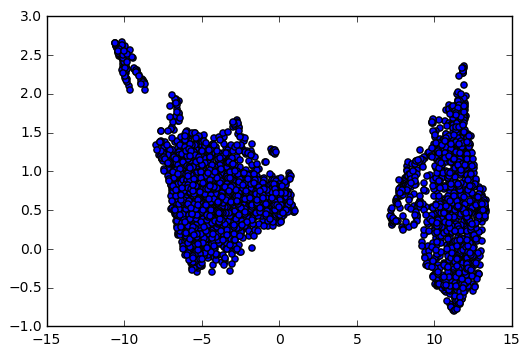

In [24]:
_ = plt.scatter(X_tiles_transformed.T[0], X_tiles_transformed.T[1])

In [25]:
# clf = KMeans(n_clusters=5)
# clf = AgglomerativeClustering(n_clusters=5)
clf = DBSCAN(eps=0.5)
# clf = GaussianMixture(n_components=2)

In [26]:
# clf.fit(X_tiles_transformed)
# y_tiles = clf.predict(X_tiles_transformed)

y_tiles = clf.fit_predict(X_tiles_transformed)

In [27]:
set(y_tiles)

{0, 1, 2}

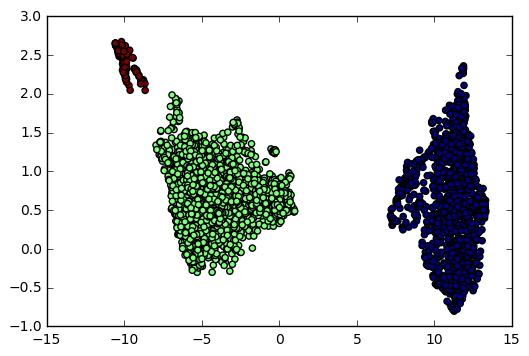

In [28]:
_ = plt.scatter(X_tiles_transformed.T[0], X_tiles_transformed.T[1], c=y_tiles)

In [31]:
tile_grid = [(i, j) for i in range(48) for j in range(64)]

TARGET_CLASS = 0

white_filter = PIL.Image.fromarray(np.uint8(255*np.ones(img_as_arr.shape)))

img_copy = img.copy()
mask = np.zeros(img_as_arr.shape[:2])
for idx, tile in enumerate(tile_grid):
    if y_tiles[idx] != TARGET_CLASS:
        i, j = tile
        mask[DPI*i:DPI*(i+1),DPI*j:DPI*(j+1)] = 1

img_copy.paste(white_filter, (0, 0), PIL.Image.fromarray(np.uint8(255*mask)))

In [47]:
# img_copy

## Pixel visualization in 2d (RG channels only)

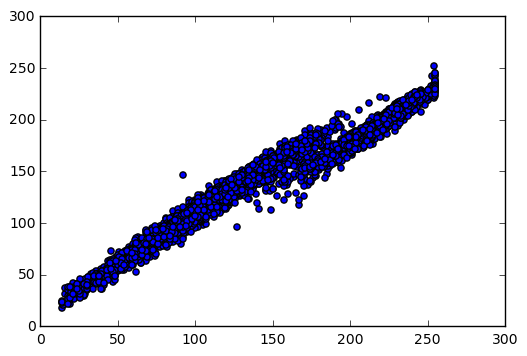

In [33]:
_ = plt.scatter(xs_sample, ys_sample)

## Pixel visualisation in 3d

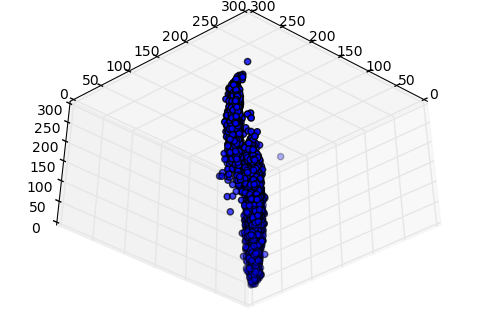

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
_ = ax.scatter(xs_sample, ys_sample, zs_sample)
ax.azim = 45
ax.elev = -45

## Pixel clustering

In [35]:
# clf = KMeans(n_clusters=2)
# clf = AgglomerativeClustering(n_clusters=2)
clf = GaussianMixture(n_components=2)

In [36]:
clf.fit(X)
y = clf.predict(X)

# y = clf.fit_predict(X)

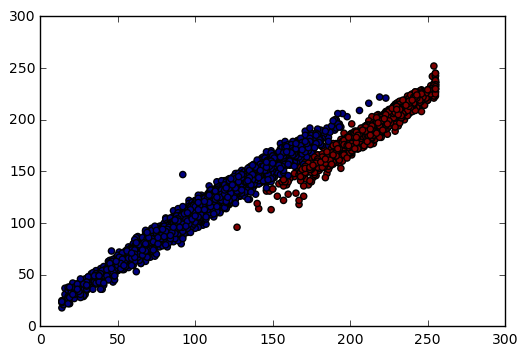

In [37]:
# _ = plt.scatter(xs_sample[y==0], ys_sample[y==0])
# _ = plt.scatter(xs_sample[y==1], ys_sample[y==1])
_ = plt.scatter(xs_sample, ys_sample, c=y)

In [38]:
X_large = np.array(zip(xs, ys, zs))

In [39]:
y_large = clf.predict(X_large).reshape(img_as_arr.shape[:2])

In [40]:
y_large.shape

(3456, 4608)

In [41]:
y_large[-10:, -10:]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [42]:
img_copy1, img_copy2 = img.copy(), img.copy()
mask1 = PIL.Image.fromarray(np.uint8(255*y_large))
mask2 = PIL.Image.fromarray(np.uint8(255*((y_large + 1) % 2)))
white_filter = PIL.Image.fromarray(np.uint8(255*np.ones(img_as_arr.shape)))

In [43]:
img_copy1.paste(white_filter, (0, 0), mask1)
img_copy2.paste(white_filter, (0, 0), mask2)

In [48]:
# img_copy1

In [49]:
# img_copy2